# Setting up the path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls
%cd drive/MyDrive/Bioinformatics/
%ls

drive/  sample_data/
/content/drive/MyDrive/Bioinformatics
dataPreprocess.py    Network.ipynb     PatientNetwork.ipynb   Trial.ipynb
dataStructure.ipynb  organization/     README.md
Directories.ipynb    PatientNet.ipynb  ShallowLearning.ipynb


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Bioinformatics')

# Creating the labels

In [ ]:
import pandas as pd
import numpy as np

diagnosi = '/content/drive/MyDrive/meso_san_luigi/diagnosi.xls'

#Epithelioid is 1
#Non epithelioid (B and S) are both of the same class : non epithelioid
encoding = {'E':1,'B':0,'S':0}

#Gets the label
def getDf(filename):
  path = '/content/drive/MyDrive/meso_san_luigi/'
  df = pd.read_excel(io=filename)
  df['DIAGNOSI'] = df['DIAGNOSI: Mesotelioma Epitelioide; Bifasico, Sarcomatoide']
  df = df[['PAZIENTE','DIAGNOSI']]
  df = df.dropna()
  patientNumbers = df['PAZIENTE'].map(lambda a: str(a).split(' ')[1].replace('TOR',''))
  df['PAZIENTE'] = df['PAZIENTE'].map(lambda a : path + str(a).split(' ')[1].replace('TOR','M-') + '.ndpi')
  df['DIAGNOSI'] = df['DIAGNOSI'].map(lambda a : encoding[a])


  return df,patientNumbers

df,pNum=getDf(diagnosi)
paths = np.array(df['PAZIENTE'])
labels = np.array(df['DIAGNOSI'])

# Importing the pickles

In [ ]:
import os
import pickle

all_features = {}
path = '/content/drive/MyDrive/BioinfoImages/patientFeatures/'

for feature in os.listdir(path):
  filename = path + feature

  if 'SmallFeature' in filename:
    current_feature = pickle.load(open(filename,"rb"))
    all_features.update(current_feature)

In [ ]:
all_features = {key : value for (key,value) in all_features.items() if type(value) != np.float64}

In [ ]:
dfFit = pd.DataFrame.from_dict(all_features,orient='index',columns=["epithelioid","non","useless"])
dfFit = dfFit.reset_index().rename(columns={'index':'PAZIENTE'})
dataset = pd.merge(dfFit,df,on='PAZIENTE')
dataset = dataset.rename(columns = {'DIAGNOSI':'label'})

In [ ]:
dataset

,PAZIENTE,epithelioid,non,useless,label
0,/content/drive/MyDrive/meso_san_luigi/M-1.ndpi,5391.789551,5746.389160,540.820557,0
1,/content/drive/MyDrive/meso_san_luigi/M-10.ndpi,2791.386475,2632.429199,166.183868,1
2,/content/drive/MyDrive/meso_san_luigi/M-44.ndpi,2039.272949,1157.257568,460.469604,1
3,/content/drive/MyDrive/meso_san_luigi/M-45.ndpi,13094.708984,5592.917480,1035.375977,1
4,/content/drive/MyDrive/meso_san_luigi/M-46.ndpi,7141.227539,5723.562988,510.207336,1
...,...,...,...,...,...
109,/content/drive/MyDrive/meso_san_luigi/M-89.ndpi,3419.622070,2874.378418,360.999146,1
110,/content/drive/MyDrive/meso_san_luigi/M-85.ndpi,36386.183594,21200.000000,5644.827148,1
111,/content/drive/MyDrive/meso_san_luigi/M-68.ndpi,31392.984375,25528.000000,2726.013184,1
112,/content/drive/MyDrive/meso_san_luigi/M-70.ndpi,57607.964844,18582.972656,3936.078369,1


# Plotting

In [ ]:
import plotly.express as px
fig = px.scatter_matrix(dataset, dimensions=["epithelioid", "non", "useless"],
                        color_continuous_scale=['#EC8172','#8993f8'], color="label")
fig.show()

# Usnig a standard scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(dataset[['epithelioid','non','useless']])

In [ ]:
dataset_scaled = pd.DataFrame(dataset_scaled,columns=['epithelioid','non','useless'])
dataset_scaled = pd.concat([dataset_scaled,dataset['label']],axis = 1)

In [ ]:
fig = px.scatter_matrix(dataset_scaled, dimensions=["epithelioid", "non", "useless"],
                        color_continuous_scale=['#EC8172','#8993f8'], color="label")
fig.show()

# Viewing class distribution

In [ ]:
import plotly.graph_objects as go

labels = dataset_scaled.groupby(['label']).size()


fig = go.Figure()
fig.add_trace(go.Bar(name="non", x=["count"], y=[labels[0]]))
fig.add_trace(go.Bar(name="epithelioid", x=["count"], y=[labels[1]]))
fig.show()

# Viewing correlation matrix

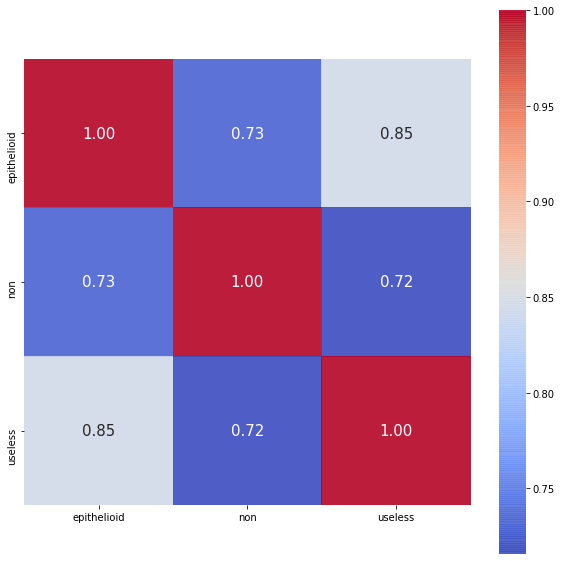

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = dataset_scaled.columns[:-1].tolist()
corr = dataset_scaled[features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.9,   cmap= 'coolwarm')
plt.show()

# Majority voting

In [ ]:
def majority_voting(df,array=False):
  if(array):
    predictions = [np.argmax(x)^1 for x in df]

    return np.array(predictions)

  predictions=df.apply((lambda x: np.argmax(x[['epithelioid','non']]) ),axis=1)
  return predictions

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_majority(df):
  mesh_size = .02
  margin = 0.25

  color_label={1:'#EC8172',0:'#8993f8'}

  # Create a mesh grid on which we will run our model
  x_min, x_max = np.min(df['epithelioid']) - margin, np.max(df['epithelioid']) + margin
  y_min, y_max = np.min(df['non']) - margin, np.max(df['non']) + margin
  xrange = np.arange(x_min, x_max, mesh_size)
  yrange = np.arange(y_min, y_max, mesh_size)
  xx, yy = np.meshgrid(xrange, yrange)

  Z = majority_voting(np.c_[xx.ravel(), yy.ravel()],array=True) #[:, 1]
  Z = Z.reshape(xx.shape)


  # Plot the figure
  fig = go.Figure(data=[
      go.Scatter( x = df['epithelioid'], y =df['non'], mode='markers', 
                marker_color=[color_label[x] for x in df['label']], marker_size = 25
      )
  ])


  fig.add_trace(
      go.Contour(
          x=xrange,
          y=yrange,
          z=Z,
          colorscale=['#d7ebef','#b84f47']
      )
    )


  fig.show()

In [ ]:
plot_majority(dataset_scaled)

### Measuring accuracy

In [ ]:
from sklearn.metrics import accuracy_score
y_true = dataset_scaled['label']
y_pred = majority_voting(dataset_scaled)

ac1=majority_accuracy=accuracy_score(y_true, y_pred)
print(ac1)

0.5087719298245614


In [ ]:
from sklearn.metrics import f1_score
f1= f1_score(y_true,y_pred)
print(f1)

0.6455696202531644


# Divding in train, validation and test
After this we we try to solve the class imblance problem in the train set, and not in the validation and testing

In [ ]:
from sklearn.model_selection import train_test_split
X, y = dataset_scaled.drop(['label'],axis=1), dataset_scaled['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42, stratify=y)

In [ ]:
y_train.value_counts().to_dict()

{0: 17, 1: 59}

In [ ]:
def plot_train_test(y_train,y_test,title):

  train_dist=y_train.value_counts().to_dict()
  test_dist=y_test.value_counts().to_dict()

  fig = go.Figure()
  fig.add_trace(go.Bar(name="epithelioid", x=["training","test"], y=[train_dist[1],test_dist[1]] ))
  fig.add_trace(go.Bar(name="non", x=["training","test"], y=[train_dist[0],test_dist[0] ]))
  fig.update_layout(title=title)
  fig.show()

In [ ]:
plot_train_test(y_train,y_test,"Train test distribution")

# SMOTE

In [ ]:
!pip install imbalanced-learn

Sampling strategy represents the proportion relationship between majority and minory classes that you want after the over/under sampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

#Definition of our over/under sampling strategy
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.55)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)


X_smote, y_smote = pipeline.fit_resample(X_train, y_train)
df_smote = pd.DataFrame(X_smote, columns=['epithelioid','non','useless'])
df_smote['label'] = y_smote

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
fig = px.scatter_matrix(df_smote, dimensions=["epithelioid", "non", "useless"],
                        color_continuous_scale=['#EC8172','#8993f8'], color="label")
fig.show()

In [ ]:
plot_train_test(df_smote['label'],y_test,"Train with smote and test distribution")

# Function for plotting the decision boundary

In [ ]:
from matplotlib.colors import ListedColormap
def plot_decision_boundaries(df,clf):
  mesh_size = 0.02 * 10
  margin = 0.25 * 10
  sampling_points = 100

  #epithelioid is 1 
  #non is 0
  color_label={1:'#8993f8',0:'#EC8172'}

  # Create a mesh grid on which we will run our model
  x_min, x_max = np.min(df['epithelioid']) - margin, np.max(df['epithelioid']) + margin
  y_min, y_max = np.min(df['non']) - margin, np.max(df['non']) + margin
  z_min, z_max = np.min(df['useless']) - margin, np.max(df['useless']) + margin

  xrange = np.linspace(x_min, x_max, sampling_points)
  yrange = np.linspace(y_min, y_max, sampling_points)
  zrange = np.linspace(z_min,z_max, sampling_points)

  xx, yy, zz= np.meshgrid(xrange,yrange,zrange)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) #[:, 1]
  Z = Z.reshape(xx.shape)


  # Plot the figure
  fig = go.Figure(data=[
      go.Scatter( x = df['epithelioid'], y =df['non'], mode='markers', 
                marker_color=[color_label[x] for x in df['label']], marker_size = 25
      )
  ])


  fig.add_trace(
      go.Contour(
          x=xrange,
          y=yrange,
          z=Z,
          colorscale=['#d7ebef','#b84f47']
      )
    )
  
  fig.show()

# SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm_pipeline = Pipeline([('o', over), ('u', under),('clf',SVC())])
params_svc={
            'clf__C': [0.001, 0.01, 0.1, 1],'clf__gamma': [0.001, 0.01, 0.1, 1],
            'clf__kernel':['linear','rbf']
        }
grid = GridSearchCV(svm_pipeline, param_grid = params_svc, cv = 5)
grid_result = grid.fit(X_train,y_train)
best_params = grid_result.best_params_

best_score=grid_result.best_score_
best_svc = SVC(C=best_params["clf__C"],gamma=best_params["clf__gamma"], kernel=best_params["clf__kernel"])



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

# Function for printing f1 score and accuracy

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

def see_scores(clf,X_test,y_test):
  y_predicted = clf.predict(X_test)
  accuracy = clf.score(X_test,y_test)
  f = f1_score(y_test,y_predicted)
  
  print(f'The accuracy is {clf.score(X_test,y_test)}')
  print(f'The f1 score is {f1_score(y_test,y_predicted)}')

  plot_confusion_matrix(clf, X_test, y_test, cmap='coolwarm', display_labels=["non","epithelioid"])  
  plt.show() 
  return accuracy, f

The accuracy is 0.7894736842105263
The f1 score is 0.8823529411764706


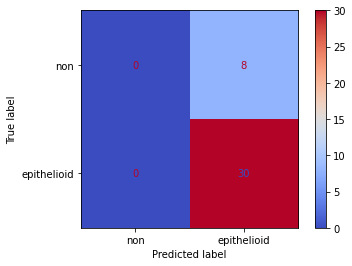

In [ ]:
ac2, f2= see_scores(grid_result,X_test,y_test)



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC

classifier=SVC()

gsc = GridSearchCV(
        estimator=classifier,
        param_grid={
            'C': [0.001, 0.01, 0.1, 1],'gamma': [0.001, 0.01, 0.1, 1],
            'kernel':['linear','rbf']

        },
        cv=2,  verbose=0, n_jobs=-1)

grid_result_nosmote = gsc.fit(df_smote[['epithelioid','non','useless']], df_smote['label'])
best_params = grid_result.best_params_
best_score=grid_result.best_score_
#best_svc = SVC(C=best_params["C"],gamma=best_params["gamma"], kernel=best_params["kernel"])

print(best_params)
print(best_score)

{'clf__C': 0.001, 'clf__gamma': 0.001, 'clf__kernel': 'linear'}
0.7766666666666667


The accuracy is 0.7105263157894737
The f1 score is 0.8307692307692307


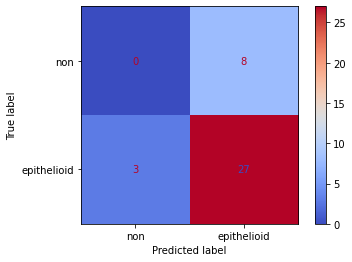

(0.7105263157894737, 0.8307692307692307)

In [ ]:
see_scores(grid_result_nosmote,X_test,y_test)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline([('o', over), ('u', under),('clf',KNeighborsClassifier())])
params_knn={
            'clf__n_neighbors': [3,5,7]
        }
gridknn = GridSearchCV(knn_pipeline, param_grid = params_knn, cv = 5)
grid_resultknn = gridknn.fit(X_train,y_train)
best_params = grid_resultknn.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

In [ ]:
best_params

{'clf__n_neighbors': 5}

The accuracy is 0.6842105263157895
The f1 score is 0.793103448275862


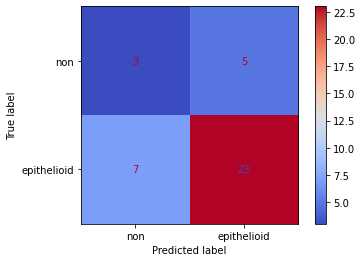

In [ ]:
ac3, f3 = see_scores(grid_resultknn,X_test,y_test)

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('o', over), ('u', under),('clf',RandomForestClassifier())])
params_rf={
            'clf__min_samples_leaf': [2,3,4],
            'clf__n_estimators' :[50,75,100]
        }
gridrf = GridSearchCV(rf_pipeline, param_grid = params_rf, cv = 5)
grid_resultrf = gridrf.fit(X_train,y_train)
best_params = grid_resultrf.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

In [ ]:
best_params

{'clf__min_samples_leaf': 2, 'clf__n_estimators': 100}

The accuracy is 0.7105263157894737
The f1 score is 0.8307692307692307


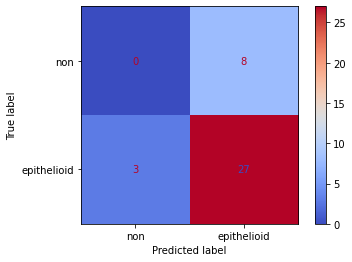

In [ ]:
ac4, f4 = see_scores(grid_resultrf,X_test,y_test)

[Text(0, 0, 'epithelioid'), Text(0, 0, 'non'), Text(0, 0, 'useless')]

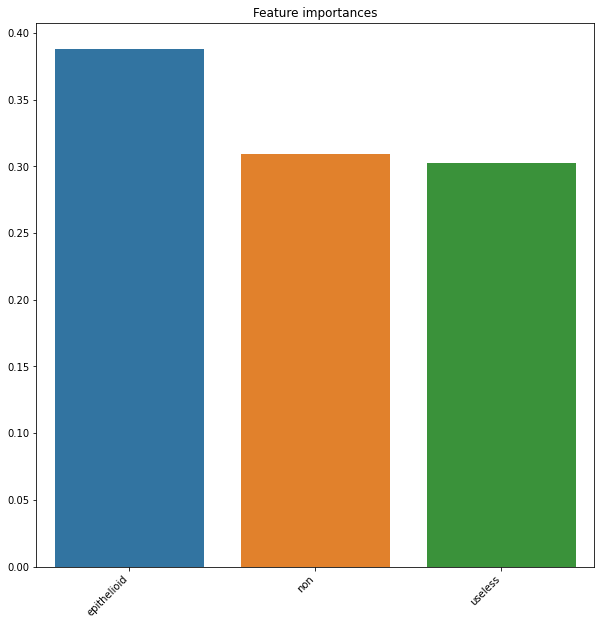

In [ ]:
import seaborn as sns
classifier=RandomForestClassifier(min_samples_leaf=3,n_estimators=75)
classifier.fit(X_train,y_train)
importances = classifier.feature_importances_
names = df_smote.columns[0:3]
f, ax = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
sns.barplot(x=names, y=importances,ax=ax)
ax.set_title(f'Feature importances')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('o', over), ('u', under),('clf',RandomForestClassifier(oob_score=True))])
params_rf={
            'clf__min_samples_leaf': [2,3,4],
            'clf__n_estimators' :[50,75,100]
        }
gridrf = GridSearchCV(rf_pipeline, param_grid = params_rf, cv = 5)
grid_resultrf = gridrf.fit(X,y)
best_params = grid_resultrf.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

In [ ]:
best_params

{'clf__min_samples_leaf': 4, 'clf__n_estimators': 50}

In [ ]:
model = RandomForestClassifier(min_samples_leaf=4,n_estimators=50, oob_score=True)
model.fit(X,y)

model.oob_score_

0.7719298245614035

# LOGISIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([('o', over), ('u', under),('clf',LogisticRegression())])
params_lr={
            'clf__C': [0.001, 0.01, 0.1, 1, 10]
            
        }
gridlr = GridSearchCV(lr_pipeline, param_grid = params_lr, cv = 5)
grid_resultlr = gridlr.fit(X_train,y_train)
best_params = grid_resultlr.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

In [ ]:
best_params

{'clf__C': 0.001}

The accuracy is 0.7894736842105263
The f1 score is 0.8823529411764706


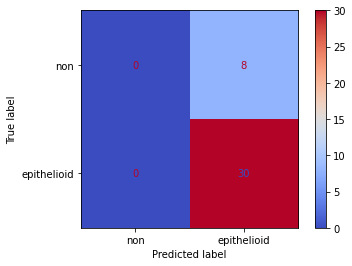

In [ ]:
ac5, f5 = see_scores(grid_resultlr,X_test,y_test)

In [ ]:
model = LogisticRegression(C=0.001)
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance


Feature: 0, Score: 0.00287
Feature: 1, Score: -0.00109
Feature: 2, Score: 0.00305


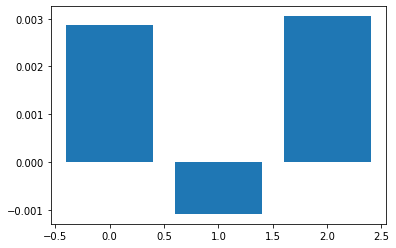

In [ ]:
import matplotlib.pyplot as plt

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:

models =[('Logistic Regression', ac5, f5),
          ('KNN', ac3, f3),
          ('majority voting' , ac1, f1),
          ('SVM ', ac2, f2),
          ('Random Forest Classification', ac4, f4),
          ]
predict = pd.DataFrame(data = models, columns=['Model', 'Test Accuracy', 'Test F1-score'])
predict


,Model,Test Accuracy,Test F1-score
0,Logistic Regression,0.789474,0.882353
1,KNN,0.684211,0.793103
2,majority voting,0.508772,0.645570
3,SVM,0.789474,0.882353
4,Random Forest Classification,0.710526,0.830769


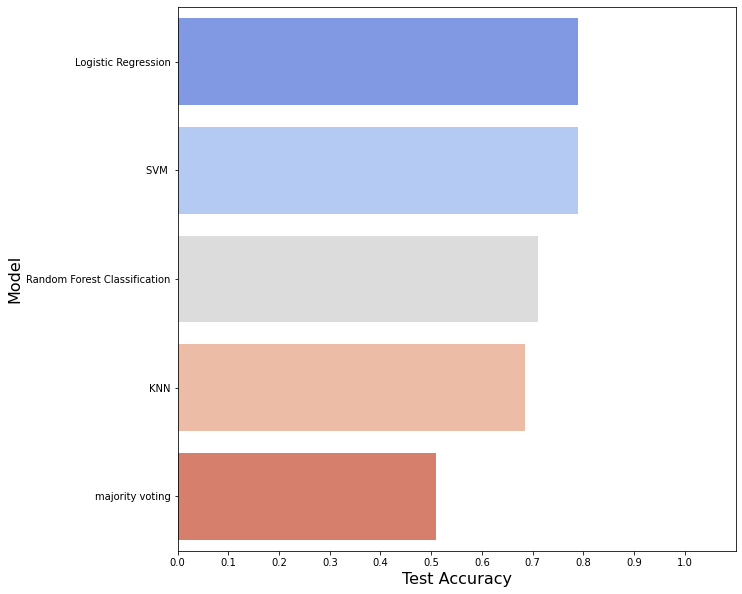

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,10))


predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='coolwarm', ax = ax)
#axes[0].set(xlabel='Region', ylabel='Charges')
ax.set_xlabel('Test Accuracy', size=16)
ax.set_ylabel('Model',size=16)
ax.set_xlim(0,1.1)
ax.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

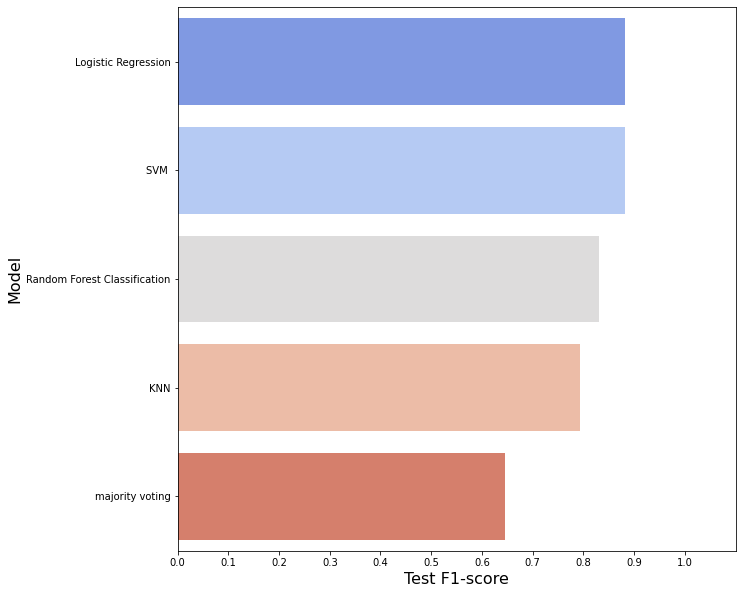

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,10))


predict.sort_values(by=['Test F1-score'], ascending=False, inplace=True)

sns.barplot(x='Test F1-score', y='Model', data = predict, palette='coolwarm', ax = ax)
#axes[0].set(xlabel='Region', ylabel='Charges')
ax.set_xlabel('Test F1-score', size=16)
ax.set_ylabel('Model',size=16)
ax.set_xlim(0,1.1)
ax.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()